# Prerequisite

## Download nltk

This work makes havy use of the nltk-framework, the download can be startet with: '#nltk.download()'

In [10]:
import nltk

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

## Checking for GPU

*If you dont have a GPU in your maschine you can ignore these section*

For better performece we recomend using your GPU, if none is detectet consider adding it to your python-enviroment.

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

print("There is", len(gpus), "detected GPU")
print("There is", len(cpus), "detected CPU")

There is 1 detected GPU
There is 1 detected CPU


In addition we recommond enlable memory growth

In [1]:
# https://medium.com/@starriet87/tensorflow-2-0-wanna-limit-gpu-memory-10ad474e2528
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Prepare Data for preprocessing

## Load form Disk and join

We load the required data into to a pandas dataframes and join them by a common field.
for convinient use we transform all identifyers to lower case

In [4]:
import pandas as pd

song_df = pd.read_csv('./song-lyrics/lyrics-data.csv')
author_df = pd.read_csv('./song-lyrics/artists-data.csv')

song_df = song_df.rename(columns={'ALink': 'Link'})

raw_df = song_df.merge(author_df, on='Link') 
raw_df.columns = raw_df.columns.str.lower()

print("There are", len(raw_df), "datasets loaded")

There are 227513 datasets loaded


## Remove unneedet data

we removed all samples which arnt english or are duplicates

In [5]:
import pandas as pd

columns_to_drop = ['sname','slink','link', 'popularity', 'genres', 'songs', 'link', 'idiom']

filterd_df = raw_df[raw_df.idiom.eq('ENGLISH')]
filterd_df = filterd_df.drop_duplicates(subset='slink', keep='first') 
filterd_df = filterd_df.drop(columns_to_drop, axis=1)

# General preprocessing

for further procssesing the lyrics get tokenized, lemmatized and cleand

In [6]:
import pandas as pd

transformed_df = filterd_df

## Lowercase

In [7]:
import pandas as pd

transformed_df['lyric'] = transformed_df['lyric'].str.lower()

## Tokenize

In [8]:
import nltk

def lyric_to_verse(lyric):
    return nltk.sent_tokenize(lyric,language='english')

def verse_to_word(verse):
    return nltk.word_tokenize(verse, language='english')

transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: lyric_to_verse(x)) 
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: [verse_to_word(verse) for verse in x]) 

## Lemmatiz

In [9]:
import nltk
from nltk.corpus import wordnet


#by http://textmining.wp.hs-hannover.de/Preprocessing.html
def pos_tagger(sentences):
    return [nltk.pos_tag(sent) for sent in sentences]

def wntag(pttag):
    if pttag in ['JJ', 'JJR', 'JJS']:
        return wordnet.ADJ
    elif pttag in ['NN', 'NNS', 'NNP', 'NNPS']:
        return wordnet.NOUN
    elif pttag in ['RB', 'RBR', 'RBS']:
        return wordnet.ADV
    elif pttag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
        return wordnet.VERB
    return None

def lemmatize(lemmatizer,word,pos):
    if pos == None:
        return word
    else:
        return lemmatizer.lemmatize(word,pos)
    
def lem(sentences):
    transformed = []
    for sentence in sentences:
        transformed.append([lemmatize(lemmatizer,word,wntag(pos)) for (word,pos) in sentence])
    return transformed 

lemmatizer = nltk.WordNetLemmatizer()

transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: pos_tagger(x)) 
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: lem(x)) 

## Cleanup

we remove any artefacts which surviced lematisation like empty words, single letter words and all non alphabetic characters 

In [12]:
import re

def clean_non_alphabetic_characters(sentences):
    cleaned = []
    for sentence in sentences:
        cleaned.append(list(map(lambda x: re.sub("[\W_]", '', x), sentence)))
    return cleaned

def clean_empty_words(sentences):
    cleaned = []
    for sentence in sentences:
        cleaned.append(list(filter(lambda x: x != '' and x != "", sentence)))
    return cleaned

def clean_single_letters(sentences):
    cleaned = []
    for sentence in sentences:
        cleaned.append(list(filter(lambda x: len(x) != 1, sentence)))
    return cleaned

def clean_empty_sentences(sentences):
    return list(filter(lambda x : len(x) != 0, sentences))

transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: clean_non_alphabetic_characters(x)) 
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: clean_empty_words(x))  
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: clean_single_letters(x)) 
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: clean_empty_sentences(x)) 

# Store preproccesd data

## Save to disk

In [13]:
transformed_df.to_csv (r'./export_dataframe.csv', index = False, header=True)

# Optional preprocessing

optianl preprocessing flatted die daten immer
BUG: wenn man es das erste mal ausfrührt muss man eine zeile im helper auskommentieren die probiert die später erstellte datei zu erstellen, rennen hier etwas in ein henne ei problem

In [12]:
from helper import get_fresh_flatted_copy

transformed_opt_df = get_fresh_flatted_copy(1)

## Remove to long Lyrics

beschreiben das wir das geprüft haben und es qasi nicht lohnt etwas zu entferne weil man den bulshit nicht vom rest spearieren kann

In [13]:
import pandas as pd

def identifyLongLyrics(data_df, capsize = 1500):
    data_df['size'] = data_df['lyric'].transform(lambda x: len(x))  
    data_df = data_df.query('size <= ' + str(capsize))
    return data_df
    
    
def identifyShortLyrics(data_df, minSize = 10):
    data_df['size'] = data_df['lyric'].transform(lambda x: len(x))  
    data_df = data_df.query('size >= ' + str(minSize))
    return data_df

transformed_opt_df = identifyLongLyrics(transformed_opt_df)
transformed_opt_df = identifyShortLyrics(transformed_opt_df)

## Remove additional Genres

alle generes rauswerfen die für weniger als x lieder haben 

In [15]:
import pandas as pd

def filterSmallGenres(data, level='lyric',threshold = 100):
    genres = data.genre.unique()

    df_container = {}

    for genre in genres:
        df_container[genre] = data[data.genre.eq(genre)]
    
    for key in list(df_container.keys()):
        if(len(df_container[key]) < threshold):
            del df_container[key]

    return pd.concat(df_container.values())

transformed_opt_df = filterSmallGenres(transformed_opt_df)

## Normalize dataset

schau das du von allen genres gleich viele lieder hast 

In [17]:
def normalizeData(data, level='lyric'):
    genres = data.genre.unique()

    df_container = {}

    #Baue einen dict anhand der existierenden genres
    for genre in genres:
        df_container[genre] = data[data.genre.eq(genre)]
    
    sampleSize = 0
    
    #Finde heraus welches genre die wenigsten lieder enthält
    for key in list(df_container.keys()):
        if(sampleSize == 0):
            sampleSize = len(df_container[key])
        else:
            if(len(df_container[key]) < sampleSize):
                sampleSize = len(df_container[key])
            
    #Pick mir einen Sample anhand des wertes sampleSize
    for key in list(df_container.keys()):
        df_container[key] = df_container[key].sample(n = sampleSize);
    
    return pd.concat(df_container.values())
    
transformed_opt_df = normalizeData(transformed_opt_df)

# Store optional Preprocessed data

speichern in extra datei

In [ ]:
transformed_opt_df.to_csv (r'./export_dataframe_opt.csv', index = False, header=True)

# Look at the data

## GenreDistribution

first we will look at the distribution of generes in our dataset

<AxesSubplot:xlabel='genre', ylabel='count'>

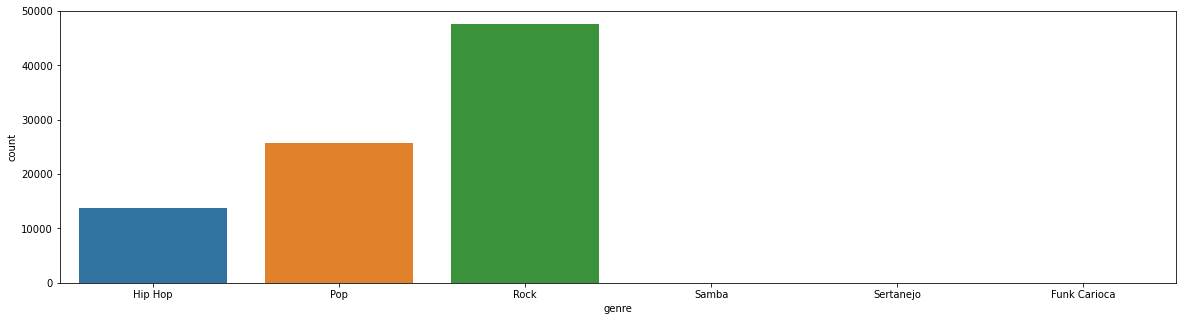

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

from helper import get_fresh_copy

plt.figure(figsize=(20, 5))
sns.countplot(data=get_fresh_copy(), x='genre')

## FreqencyDistribution

freqency distribution of the most common words in our dataset

to see if removing stopwords is a good idea we have a look ate the destribuition of stopwords over the difertent genres

In [4]:
import itertools
import nltk
import pandas as pd

def lengthDistribution(data_df):
    genres = data_df.genre.unique()

    lengthDistribution
    df_container = {}
    fd_container = {}

    total_word_count = {}

    merged_fd_df = pd.DataFrame(data = nltk.FreqDist(itertools.chain.from_iterable(data_df['lyric'])).items(), columns=['words', 'frequency'])
    merged_fd_df = merged_fd_df.sort_values("frequency", ascending=False)

    for genre in genres:
        df_container[genre] = data_df[data_df.genre.eq(genre)]
        fd_container[genre] = nltk.FreqDist(itertools.chain.from_iterable(df_container[genre]['lyric']))
        total_word_count[genre] = sum(fd_container[genre].values())
        fd_container[genre] = pd.DataFrame(fd_container[genre].items(), columns=['words', genre])
        fd_container[genre][genre] = fd_container[genre][genre].transform(lambda x: x/total_word_count[genre]) 
        merged_fd_df = merged_fd_df.merge(fd_container[genre], on='words')

    merged_fd_df = merged_fd_df.drop(['frequency'], axis=1)
    merged_fd_df = merged_fd_df.set_index('words')
    
    return merged_fd_df

### General Preprocessed Dataset

<AxesSubplot:xlabel='words'>

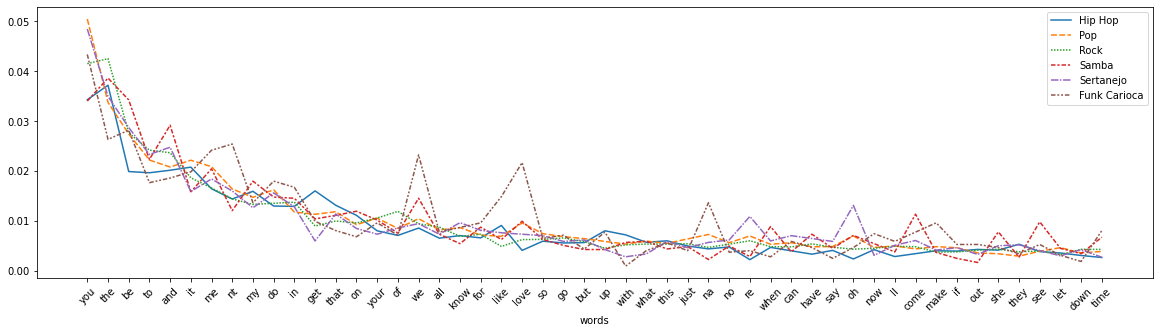

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from helper import get_fresh_flatted_copy

        
length_distribution_df = lengthDistribution(get_fresh_flatted_copy(1))

plt.figure(figsize=(20, 5))
plt.xticks(rotation=45)    
sns.lineplot(data=length_distribution_df.head(50))

### Optional Preprocessed Dataset

<AxesSubplot:xlabel='words'>

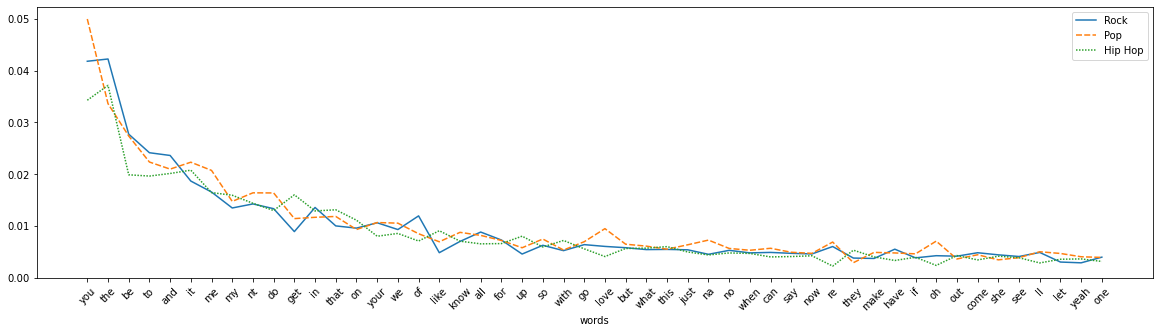

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from helper import get_fresh_copy

        
length_distribution_df = lengthDistribution(get_fresh_copy(opt=True))

plt.figure(figsize=(20, 5))
plt.xticks(rotation=45)    
sns.lineplot(data=length_distribution_df.head(50))

## Lyricslength Distribution by genre(word)

we look if some generes as more likly to have shorter or longer lyrics

In [7]:
import pickle

def freqenzyDistribution(data, level='lyric'):
    data[level] = data[level].transform(lambda x: len(x))

    genres = data.genre.unique()

    df_container = {}
    mean_container = {}
    std_container = {}
    counts_container = {}

    for genre in genres:
        df_container[genre] = pickle.loads(pickle.dumps(data[data.genre.eq(genre)]))

    for genre in genres:
        mean_container[genre] = df_container[genre][level].values.mean()

    for genre in genres:
        std_container[genre] = df_container[genre][level].values.std()

    for genre in genres:
        counts_container[genre] = df_container[genre][level].value_counts(normalize=True)

    for genre in genres:
        counts_container[genre] = pd.DataFrame.from_dict(counts_container[genre])
        counts_container[genre]['genre'] = genre
        counts_container[genre] = counts_container[genre].reset_index()
        counts_container[genre] = counts_container[genre].rename(columns={level: 'count'})
        counts_container[genre] = counts_container[genre].rename(columns={'index': 'length'})

    return pd.concat(counts_container.values())

### General Preprocessed Dataset

<AxesSubplot:xlabel='length', ylabel='count'>

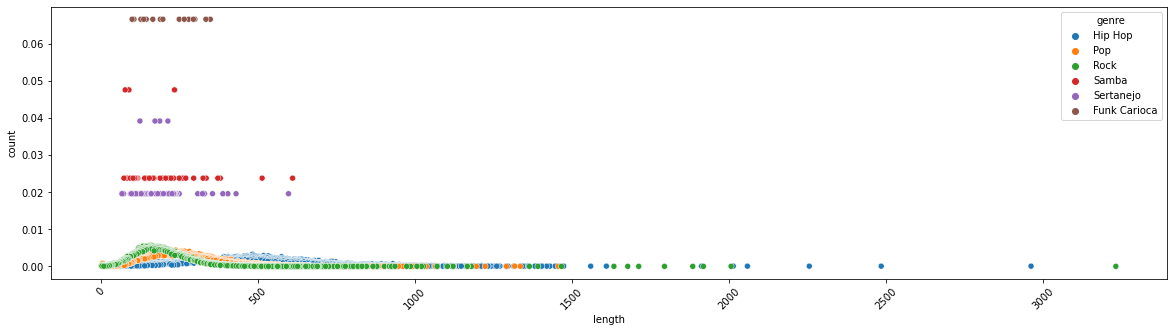

In [8]:
import itertools
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from helper import get_fresh_flatted_copy
    
        
flatted_df = get_fresh_flatted_copy(1)
result_df = freqenzyDistribution(flatted_df)

plt.figure(figsize=(20, 5))
plt.xticks(rotation=45)
sns.scatterplot(data=result_df, x="length", y="count", hue="genre")

### Optional Preprocessed Dataset

<AxesSubplot:xlabel='length', ylabel='count'>

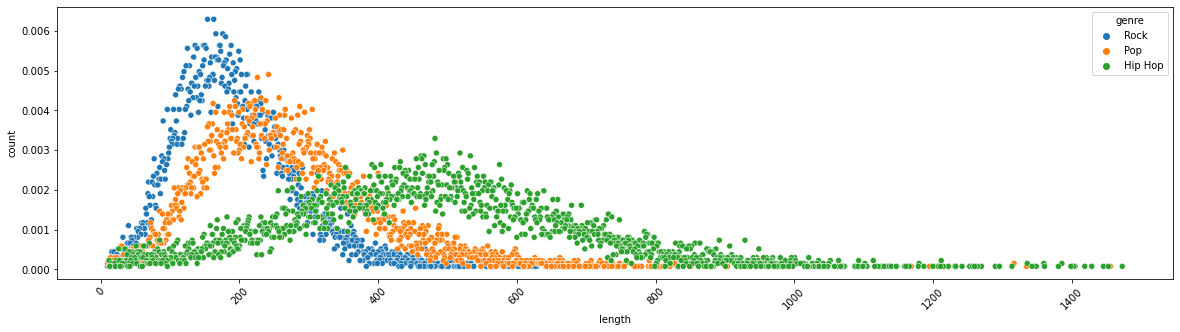

In [9]:
import itertools
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from helper import get_fresh_flatted_copy
    
        
flatted_df = get_fresh_copy(opt=True)
result_df = freqenzyDistribution(flatted_df)

plt.figure(figsize=(20, 5))
plt.xticks(rotation=45)
sns.scatterplot(data=result_df, x="length", y="count", hue="genre")

## Lyricslength Distribution by genre(vers)


we look if some generes as more likly to have shorter or longer lyrics
nur für die ungeflatted version da opt preprocessing immer flatted und verse 

<AxesSubplot:xlabel='length', ylabel='count'>

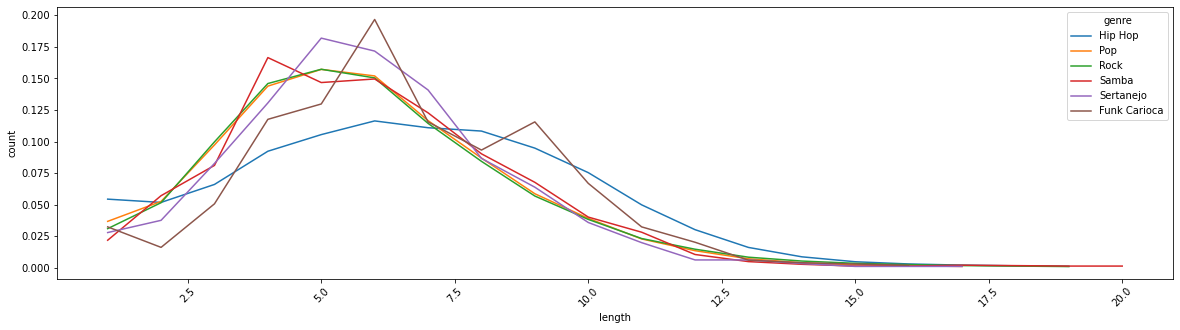

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from helper import get_fresh_copy, melt

flatted_df = get_fresh_copy(1)
flatted_df = pd.DataFrame(melt(flatted_df))

result_df = freqenzyDistribution(flatted_df, 'verse')

plt.figure(figsize=(20, 5))
plt.xticks(rotation=45)
sns.lineplot(data=result_df[result_df['count']>= 0.001], x="length", y="count", hue="genre")

## Lyricslength Distribution by genre(lyric/verse)

we look if some generes as more likly to have shorter or longer lyrics

<AxesSubplot:xlabel='length', ylabel='count'>

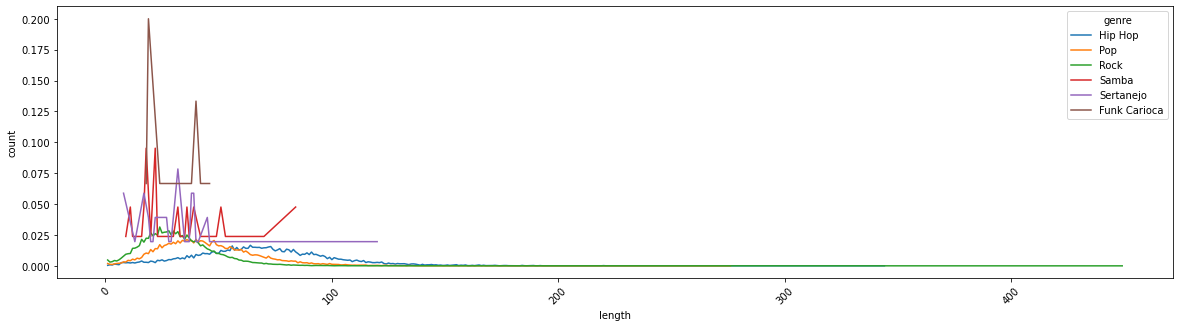

In [12]:
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from helper import get_fresh_copy

flatted_df = get_fresh_copy(1)
result_df = freqenzyDistribution(flatted_df)

plt.figure(figsize=(20, 5))
plt.xticks(rotation=45)
sns.lineplot(data=result_df, x="length", y="count", hue="genre")

In [13]:
#todo nachschauen wieviele wörter wie oft auftauchen
#wäre cool wenn wir das noch hinbekommen aber das formulieren der texte ist viel wichtiger

# Learning

## Simple Neural Networks

In [6]:
# Move to Helper
#https://stackoverflow.com/questions/42406233/how-to-add-title-to-seaborn-boxplot
def print_graph(history_a, history_b):
    history_df = pd.DataFrame(history_a.history)

    plt.figure(figsize=(20, 5))
    plt.xticks(rotation=45)
    sns.lineplot(data=history_df).set_title('General Data')

    history_df = pd.DataFrame(history_b.history)

    plt.figure(figsize=(20, 5))
    plt.xticks(rotation=45)
    sns.lineplot(data=history_df).set_title("Optional Data")

### Prepare Data

In [7]:
import keras
from keras.preprocessing.text import Tokenizer

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from helper import get_fresh_flatted_copy, get_fresh_copy

def prepData(data_df):
    preprocessed_df = data_df

    x_train, x_test, y_train, y_test = train_test_split(preprocessed_df['lyric'], preprocessed_df['genre'], test_size=0.20)
    tokenizer = Tokenizer(num_words=10000)

    le = preprocessing.LabelEncoder()
    le.fit(y_train)
    y_train = le.transform(y_train)
    y_test = le.transform(y_test)

    num_classes =  len(preprocessed_df['genre'].unique())
    tokenizer.fit_on_texts(x_train)

    x_train = tokenizer.texts_to_matrix(x_train, mode='tfidf')
    x_test = tokenizer.texts_to_matrix(x_test, mode='tfidf')

    y_train = keras.utils.to_categorical(y_train)
    y_test = keras.utils.to_categorical(y_test)
    
    return x_train, x_test, y_train, y_test, num_classes

g_x_train, g_x_test, g_y_train, g_y_test, g_num_classes = prepData(get_fresh_flatted_copy())
o_x_train, o_x_test, o_y_train, o_y_test, o_num_classes = prepData(get_fresh_copy(opt=1))

### Shallow Neural Network

#### General Data

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(64, input_shape=(10000, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(g_num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 5

history_g = model.fit(g_x_train, g_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)
score_g = model.evaluate(g_x_test, g_y_test, batch_size=batch_size, verbose=1)

Epoch 1/5
1961/1961 [==============================] - 4s 2ms/step - loss: 0.6882 - accuracy: 0.7122 - val_loss: 0.5889 - val_accuracy: 0.7639
Epoch 2/5
1961/1961 [==============================] - 3s 2ms/step - loss: 0.5499 - accuracy: 0.7705 - val_loss: 0.5777 - val_accuracy: 0.7676
Epoch 3/5
1961/1961 [==============================] - 3s 2ms/step - loss: 0.4840 - accuracy: 0.7968 - val_loss: 0.5989 - val_accuracy: 0.7618
Epoch 4/5
1961/1961 [==============================] - 3s 2ms/step - loss: 0.4385 - accuracy: 0.8180 - val_loss: 0.6409 - val_accuracy: 0.7494
Epoch 5/5
545/545 [==============================] - 1s 1ms/step - loss: 0.6652 - accuracy: 0.7581


#### Optional Data

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(64, input_shape=(10000, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(o_num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 5

history_o = model.fit(o_x_train, o_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)
score_o = model.evaluate(o_x_test, o_y_test, batch_size=batch_size, verbose=1)

Epoch 1/5
923/923 [==============================] - 2s 2ms/step - loss: 0.7020 - accuracy: 0.6836 - val_loss: 0.6143 - val_accuracy: 0.7272
Epoch 2/5
923/923 [==============================] - 2s 2ms/step - loss: 0.5269 - accuracy: 0.7754 - val_loss: 0.6207 - val_accuracy: 0.7358
Epoch 3/5
923/923 [==============================] - 2s 2ms/step - loss: 0.4277 - accuracy: 0.8204 - val_loss: 0.6648 - val_accuracy: 0.7306
Epoch 4/5
923/923 [==============================] - 2s 2ms/step - loss: 0.3655 - accuracy: 0.8494 - val_loss: 0.7179 - val_accuracy: 0.7220
Epoch 5/5
257/257 [==============================] - 0s 1ms/step - loss: 0.8084 - accuracy: 0.7182


#### Results

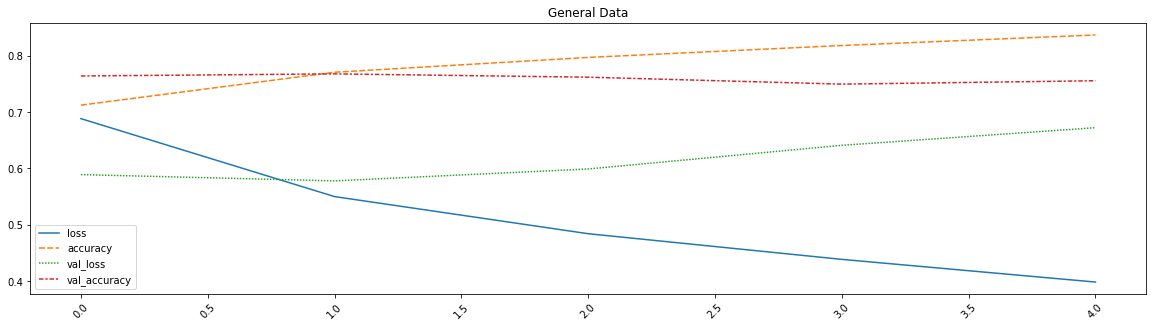

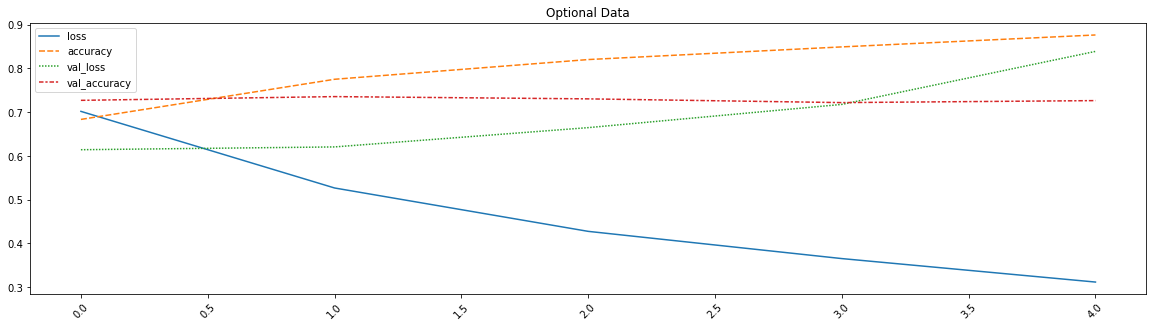

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print_graph(history_g, history_o)

### Deep Dense Neural Network

#### General Data

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(64, input_shape=(10000, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Dense(g_num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 5

history_g = model.fit(g_x_train, g_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)
score_g = model.evaluate(g_x_test, g_y_test, batch_size=batch_size, verbose=1)

Epoch 1/5
1961/1961 [==============================] - 4s 2ms/step - loss: 0.7409 - accuracy: 0.6791 - val_loss: 0.6412 - val_accuracy: 0.7316
Epoch 2/5
1961/1961 [==============================] - 4s 2ms/step - loss: 0.6192 - accuracy: 0.7402 - val_loss: 0.5947 - val_accuracy: 0.7529
Epoch 3/5
1961/1961 [==============================] - 4s 2ms/step - loss: 0.5620 - accuracy: 0.7714 - val_loss: 0.5869 - val_accuracy: 0.7616
Epoch 4/5
1961/1961 [==============================] - 8s 4ms/step - loss: 0.5207 - accuracy: 0.7919 - val_loss: 0.5943 - val_accuracy: 0.7609
Epoch 5/5
545/545 [==============================] - 1s 1ms/step - loss: 0.5977 - accuracy: 0.7526


#### Optional Data

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(64, input_shape=(10000, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Dense(o_num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 5

history_o = model.fit(o_x_train, o_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)
score_o = model.evaluate(o_x_test, o_y_test, batch_size=batch_size, verbose=1)

Epoch 1/5
923/923 [==============================] - 2s 2ms/step - loss: 0.7853 - accuracy: 0.6032 - val_loss: 0.7205 - val_accuracy: 0.6489
Epoch 2/5
923/923 [==============================] - 2s 2ms/step - loss: 0.6673 - accuracy: 0.6915 - val_loss: 0.7018 - val_accuracy: 0.6599
Epoch 3/5
923/923 [==============================] - 2s 2ms/step - loss: 0.5992 - accuracy: 0.7378 - val_loss: 0.6548 - val_accuracy: 0.6986
Epoch 4/5
923/923 [==============================] - 2s 2ms/step - loss: 0.5334 - accuracy: 0.7722 - val_loss: 0.6583 - val_accuracy: 0.7126
Epoch 5/5
257/257 [==============================] - 0s 1ms/step - loss: 0.6992 - accuracy: 0.7053


#### Results

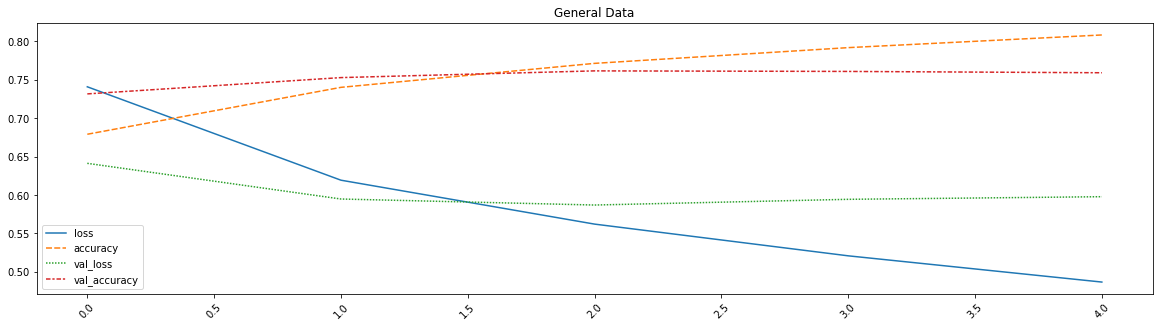

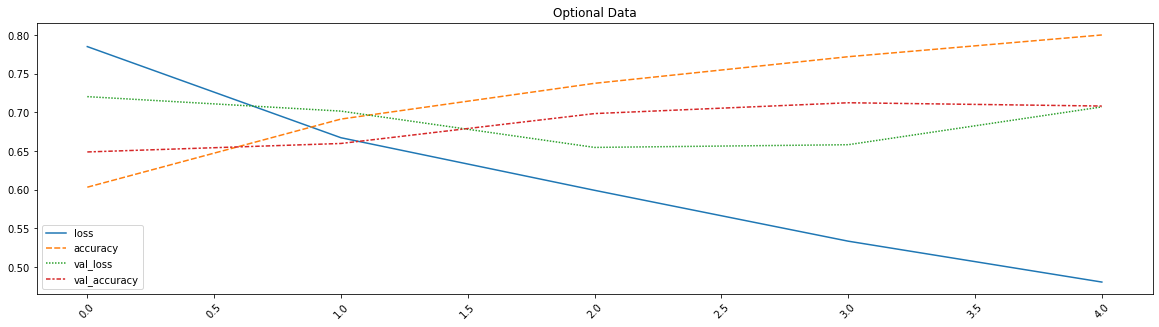

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print_graph(history_g, history_o)

### Big Deep Dense Neural Network

#### General Data

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(2048, input_shape=(10000, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2048))
model.add(Dense(g_num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 5

history_g = model.fit(g_x_train, g_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)
score_g = model.evaluate(g_x_test, g_y_test, batch_size=batch_size, verbose=1)

Epoch 1/5
1961/1961 [==============================] - 31s 16ms/step - loss: 0.7913 - accuracy: 0.6884 - val_loss: 0.6470 - val_accuracy: 0.7579
Epoch 2/5
1961/1961 [==============================] - 26s 13ms/step - loss: 0.7081 - accuracy: 0.7307 - val_loss: 0.6553 - val_accuracy: 0.7216
Epoch 3/5
1961/1961 [==============================] - 25s 13ms/step - loss: 0.6492 - accuracy: 0.7576 - val_loss: 0.7156 - val_accuracy: 0.7147
Epoch 4/5
1961/1961 [==============================] - 26s 13ms/step - loss: 0.7955 - accuracy: 0.7013 - val_loss: 0.9633 - val_accuracy: 0.6406
Epoch 5/5
545/545 [==============================] - 1s 3ms/step - loss: 1.0299 - accuracy: 0.6459


#### Optional Data

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(2048, input_shape=(10000, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2048))
model.add(Dense(o_num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 5

history_o = model.fit(o_x_train, o_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)
score_o = model.evaluate(o_x_test, o_y_test, batch_size=batch_size, verbose=1)

Epoch 1/5
923/923 [==============================] - 15s 16ms/step - loss: 0.8664 - accuracy: 0.6537 - val_loss: 0.6798 - val_accuracy: 0.7248
Epoch 2/5
923/923 [==============================] - 12s 13ms/step - loss: 0.6092 - accuracy: 0.7524 - val_loss: 0.7336 - val_accuracy: 0.6699
Epoch 3/5
923/923 [==============================] - 11s 12ms/step - loss: 0.5198 - accuracy: 0.8190 - val_loss: 0.9134 - val_accuracy: 0.7226
Epoch 4/5
923/923 [==============================] - 13s 14ms/step - loss: 0.3977 - accuracy: 0.8693 - val_loss: 1.0429 - val_accuracy: 0.7092
Epoch 5/5
257/257 [==============================] - 1s 3ms/step - loss: 1.2729 - accuracy: 0.7009


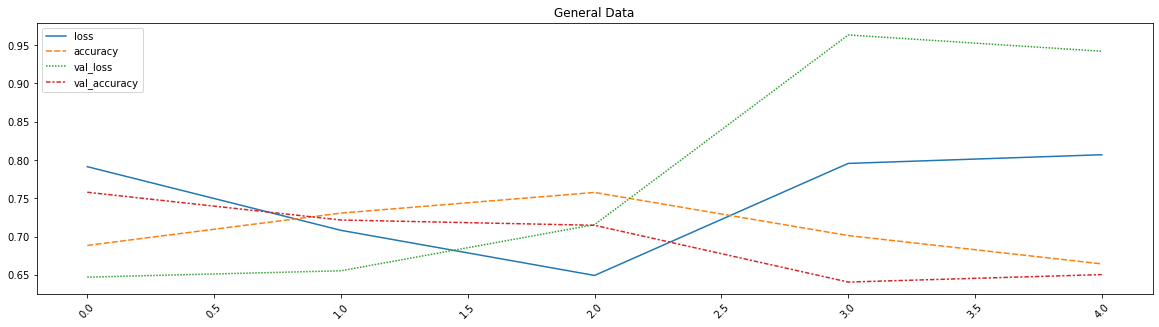

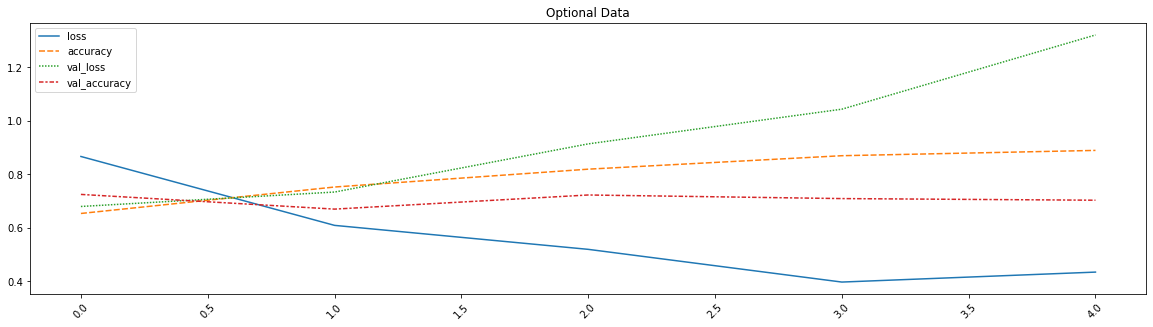

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print_graph(history_g, history_o)

## Complex Neural Networks

In [2]:
MAX_SEQUENCE_LENGTH = 400
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

### Prepare Data

load data and factorize 'genre'

#### Load Data

In [5]:
import pandas as pd
from helper import melt, get_fresh_flatted_copy

preprocessed_df = pd.DataFrame(get_fresh_flatted_copy(1))

#https://stackoverflow.com/questions/42320834/sklearn-changing-string-class-label-to-int
preprocessed_df.genre = pd.factorize(preprocessed_df.genre)[0]

In [6]:
display(preprocessed_df)

,lyric,artist,genre
51949,"[intro, akon, chamillionaire, see, remember, b...",Chamillionaire,0
64994,"[wyclef, jean, feat, canibus, kelly, khadejiah...",Wyclef Jean,0
51740,"[bun, talk, man, fo, real, love, be, from, the...",Bun-b,0
20431,"[be, weak, and, powerless, taste, oh, so, well...",Kerli,1
42178,"[sometimes, do, nt, know, what, to, think, abo...",The Flaming Lips,2
...,...,...,...
21440,"[my, mama, say, that, your, life, be, gift, an...",Lenny Kravitz,2
73349,"[not, sayin, nothin, you, do, nt, already, kno...",Gwen Stefani,1
50057,"[people, gon, talk, that, what, they, do, when...",50 Cent,0
5192,"[wan, na, drag, you, around, wan, na, drag, yo...",Blondie,2


save needed dataframes as arrays and hot-encode the label

In [7]:
import numpy as np
from keras.utils import to_categorical

labels_index = preprocessed_df['genre'].unique()
texts = np.asarray(preprocessed_df['lyric'])
labels = np.asarray(preprocessed_df['genre'])

labels = to_categorical(np.asarray(labels))

convert lyrics to verctors and pad the result

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


#### Split Data
split the data into a training set and a validation set

In [9]:
import numpy as np

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

#### Build embedding layer

#### pre-trained embedding

load the pre-trained glove-model

In [10]:
from helper import loadGloveModel

embeddings_index = loadGloveModel()

build the embedding-matrix 

In [11]:
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

build the embedding-lyer

In [12]:
from keras.layers import Embedding
from keras.initializers import Constant

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

#### not pre-trained embedding

In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH)

### Convolutional Neural Network with MaxPooling

In [16]:
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model, Sequential

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

innter_layer = Conv1D(128, 5, activation='relu')(embedded_sequences)
innter_layer = MaxPooling1D(5)(innter_layer)
innter_layer = Conv1D(128, 5, activation='relu')(innter_layer)
innter_layer = MaxPooling1D(5)(innter_layer)
innter_layer = Conv1D(128, 5, activation='relu')(innter_layer)
innter_layer = GlobalMaxPooling1D()(innter_layer)
innter_layer = Dense(64, activation='relu')(innter_layer)
innter_layer = Dropout(0.5)(innter_layer)
innter_layer = Dense(32, activation='relu')(innter_layer)
innter_layer = Dropout(0.5)(innter_layer)
innter_layer = Dense(16, activation='relu')(innter_layer)
innter_layer = Dropout(0.5)(innter_layer)

output_1 = Dense(len(labels_index), activation='softmax')(innter_layer)

model = Model(sequence_input, output_1)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=20,
          validation_data=(x_val, y_val))

Epoch 1/20
545/545 [==============================] - 9s 16ms/step - loss: 1.0290 - acc: 0.5642 - val_loss: 0.7333 - val_acc: 0.6699
Epoch 2/20
545/545 [==============================] - 8s 16ms/step - loss: 0.7824 - acc: 0.6582 - val_loss: 0.7005 - val_acc: 0.6848
Epoch 3/20
545/545 [==============================] - 9s 16ms/step - loss: 0.7423 - acc: 0.6759 - val_loss: 0.7095 - val_acc: 0.6994
Epoch 4/20
545/545 [==============================] - 8s 16ms/step - loss: 0.7159 - acc: 0.6872 - val_loss: 0.6950 - val_acc: 0.7024
Epoch 5/20
545/545 [==============================] - 9s 16ms/step - loss: 0.6971 - acc: 0.6933 - val_loss: 0.7091 - val_acc: 0.7054
Epoch 6/20
545/545 [==============================] - 8s 16ms/step - loss: 0.6893 - acc: 0.6967 - val_loss: 0.7369 - val_acc: 0.7073
Epoch 7/20
545/545 [==============================] - 9s 16ms/step - loss: 0.6787 - acc: 0.7029 - val_loss: 0.8135 - val_acc: 0.7082
Epoch 8/20
545/545 [==============================] - 9s 16ms/step - 

<AxesSubplot:>

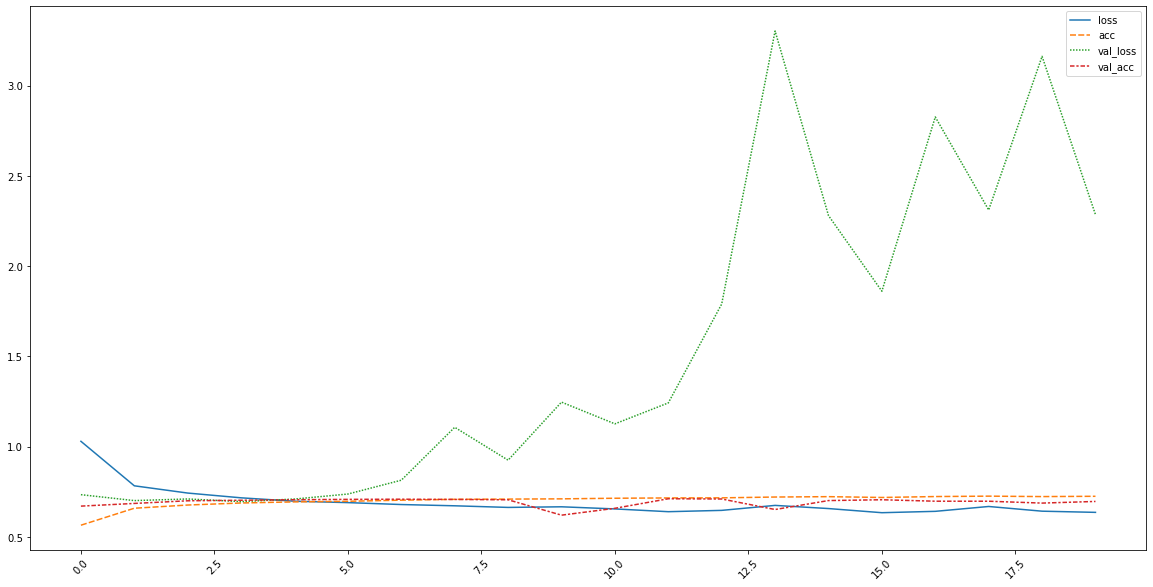

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.lineplot(data=history_df)

### Recurrent Bidirectional Neural Network

In [18]:
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Embedding, Bidirectional, LSTM, GRU
from keras.models import Model, Sequential


model = Sequential()
model.add(Embedding(num_words,
                    EMBEDDING_DIM,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))
model.add(Dropout(0.1))
model.add(Bidirectional(GRU(16, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(8)))
model.add(Dropout(0.5))
model.add(Dense(6))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])


history = model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          validation_data=(x_val, y_val))

Epoch 1/20
2179/2179 [==============================] - 91s 42ms/step - loss: 0.8646 - acc: 0.6258 - val_loss: 0.7292 - val_acc: 0.6788
Epoch 2/20
2179/2179 [==============================] - 95s 43ms/step - loss: 0.7396 - acc: 0.6790 - val_loss: 0.6763 - val_acc: 0.7026
Epoch 3/20
2179/2179 [==============================] - 95s 44ms/step - loss: 0.7082 - acc: 0.6978 - val_loss: 0.6626 - val_acc: 0.7151
Epoch 4/20
2179/2179 [==============================] - 94s 43ms/step - loss: 0.6891 - acc: 0.7082 - val_loss: 0.6974 - val_acc: 0.6900
Epoch 5/20
2179/2179 [==============================] - 94s 43ms/step - loss: 0.6723 - acc: 0.7174 - val_loss: 0.6458 - val_acc: 0.7181
Epoch 6/20
2179/2179 [==============================] - 93s 43ms/step - loss: 0.6593 - acc: 0.7224 - val_loss: 0.6271 - val_acc: 0.7342
Epoch 7/20
2179/2179 [==============================] - 93s 43ms/step - loss: 0.6506 - acc: 0.7270 - val_loss: 0.6283 - val_acc: 0.7343
Epoch 8/20
2179/2179 [==========================

<AxesSubplot:>

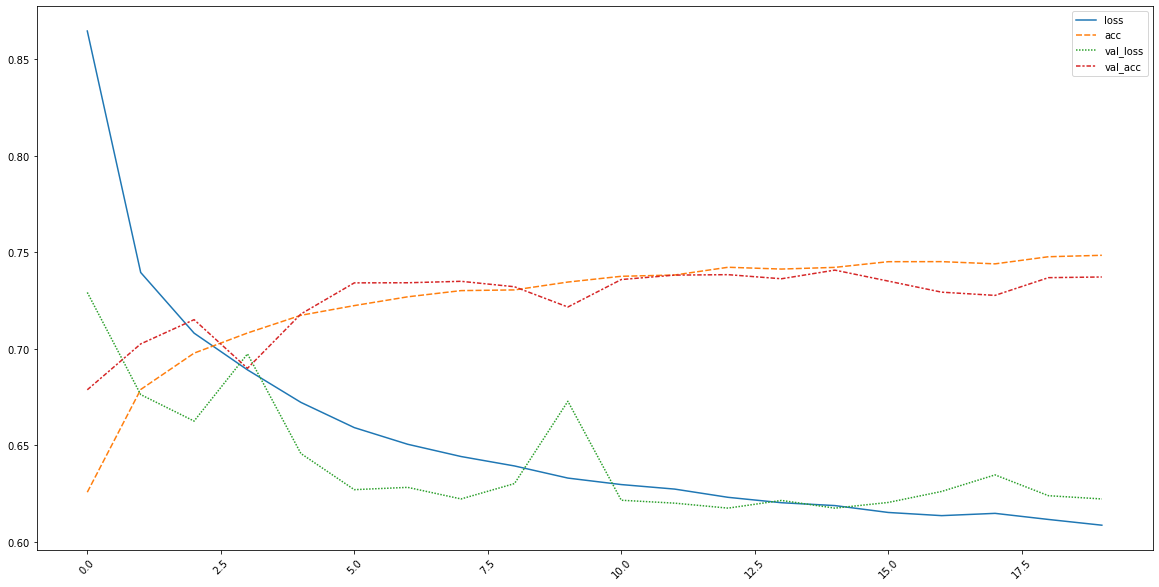

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.lineplot(data=history_df)

# Classic Machine Learning

In [36]:
import keras
from keras.preprocessing.text import Tokenizer

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from helper import get_fresh_flatted_copy, get_fresh_copy

def prepData(data_df):
    preprocessed_df = data_df

    x_train, x_test, y_train, y_test = train_test_split(list(preprocessed_df['lyric']), list(preprocessed_df['genre']), test_size=0.20)
    #tokenizer = Tokenizer(num_words=10000)

    #le = preprocessing.LabelEncoder()
    #le.fit(y_train)
    #y_train = le.transform(y_train)
    #y_test = le.transform(y_test)

    num_classes =  len(preprocessed_df['genre'].unique())
    #tokenizer.fit_on_texts(x_train)

    #x_train = tokenizer.texts_to_matrix(x_train, mode='tfidf')
    #x_test = tokenizer.texts_to_matrix(x_test, mode='tfidf')

    #y_train = keras.utils.to_categorical(y_train)
    #y_test = keras.utils.to_categorical(y_test)
    
    return x_train, x_test, y_train, y_test, num_classes

def joinSong(songs):
    result = []
    for i in songs:
        delimiter = " "
        delimiter = delimiter.join(i)
        result.append(delimiter)
    return result

x_train, x_test, y_train, y_test, num_classes = prepData(get_fresh_flatted_copy(1))
x_train = joinSong(x_train)
x_test = joinSong(x_test)

In [37]:
#https://pythonhealthcare.org/2018/12/15/104-using-free-text-for-classification-bag-of-words/
def create_bag_of_words(x):
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer(analyzer = "word",   \
                                 ngram_range = (1,2), \
                                 max_features = 10000
                                ) 

    # fit_transform() does two functions: First, it fits the model
    # and learns the vocabulary; second, it transforms our training data
    # into feature vectors. The input to fit_transform should be a list of 
    # strings. The output is a sparse array
    
    train_data_features = vectorizer.fit_transform(x)
    
    # Convert to a NumPy array for easy of handling
    train_data_features = train_data_features.toarray()
    
    # tfidf transform
    from sklearn.feature_extraction.text import TfidfTransformer
    
    tfidf = TfidfTransformer()
    tfidf_features = tfidf.fit_transform(train_data_features).toarray()

    # Get words in the vocabulary
    vocab = vectorizer.get_feature_names()
   
    return vectorizer, vocab, train_data_features, tfidf_features, tfidf

In [38]:
vectorizer, vocab, train_data_features, tfidf_features, tfidf  = create_bag_of_words(x_train)

In [40]:
import pandas as pd

bag_dictionary = pd.DataFrame()
bag_dictionary['ngram'] = vocab
bag_dictionary['count'] = train_data_features[0]
bag_dictionary['tfidf_features'] = tfidf_features[0]

# Sort by raw count
bag_dictionary.sort_values(by=['count'], ascending=False, inplace=True)
# Show top 10
display(bag_dictionary.head(10))

,ngram,count,tfidf_features
6323,rain,24,0.542662
3660,it,22,0.159101
5519,nt,22,0.174516
6837,she,15,0.230796
1948,do,14,0.109700
1983,do nt,12,0.116508
3702,it do,12,0.275468
2609,forever,10,0.225645
1325,ca,9,0.116951
1326,ca nt,9,0.117009


In [51]:
def train_logistic_regression(features, label):
    print ("Training the logistic regression model...")
    from sklearn.linear_model import LogisticRegression
    ml_model = LogisticRegression(C = 100,random_state = 0, max_iter=100)
    ml_model.fit(features, label)
    print ('Finished')
    return ml_model

In [52]:
# wenn datensatz klein ist muss man max_iter hochstellen damit es convergiert
ml_model = train_logistic_regression(tfidf_features, y_train)

Training the logistic regression model...
Finished


/home/kluhan/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
test_data_features = vectorizer.transform(x_test)
# Convert to numpy array
test_data_features = test_data_features.toarray()

In [ ]:
test_data_tfidf_features = tfidf.fit_transform(test_data_features)
# Convert to numpy array
test_data_tfidf_features = test_data_tfidf_features.toarray()

In [ ]:
import numpy as np

predicted_y = ml_model.predict(test_data_tfidf_features)
correctly_identified_y = predicted_y == y_test
accuracy = np.mean(correctly_identified_y) * 100
print ('Accuracy = %.0f%%' %accuracy)

# Summery

## Base line

* baselines berechnen 
* Loss or Accuracy

## Comparing results

## Restriction